In [27]:
#import midi2nmat as m2n
import pandas as pd
import numpy as np
import arcplot
import midi2nmat as m2n

In [28]:
#path="/Users/aaroncarter-enyi/Downloads/atavizm-SAR_dev/Data/a-exsultate.mid"
path="../Data/a-exsultate.mid"

In [29]:
test = m2n.midi2nmat(path)

In [30]:
def _make_ContCM(arr, deg1, deg2 = None):
    """
    Creates Continous Contour Matrix for searching
    Adapted for asynchrony
    """
    
    if deg2 is None:
        deg2 = deg1
    
    degrees = deg1 + deg2
    ContCM = np.zeros((degrees,len(arr))) #creates and initializes  contour matrix w/ zeroes
    ContCM.fill(np.nan)            #fills matrix with Null values
    #print(arr)
    for n in range(0,len(arr)):    
            for i in [1,2]:
                try:
                    if arr[n] > arr[n-i] and n-i >= 0 :
                        ContCM[deg1-i, n] = 1
                    elif n-i >= 0:
                        ContCM[deg1-i, n] = 0
                except:
                    continue

            for i in [1,2]:
                try:
                    if arr[n] > arr[n+i]:
                        ContCM[deg1+i-1, n] = 1
                    else:
                        ContCM[deg1+i-1, n] = 0
                except:
                    continue
    
    return ContCM

In [31]:
def _get_segments(cmin,cmax,pitches,CL_list):    
    p = []
    for n in range(cmin,cmax): #this should be a range of cardinalities to look over
        segments = [CL_list[0][i:i+n] for i in range(0, len(pitches)-n)] #get list of all possible segments of n cardinality
        segmentu = [list(x) for x in set(tuple(x) for x in segments)] #get the unique segments from the list

        segind = [[] for i in range(0,len(segmentu))] #get the index of these occurences of these segments, this also happens to be the index of the notes they start on
        for i in range(0,len(segmentu)):
            for j in range(0,len(segments)):
                if (segments[j] == segmentu[i]).all():
                    segind[i].append(j)

        if len(segments) == len(segmentu):
            break
        
        segmentucount = np.array([len(x) for x in segind]) #get a count of all the occurences for a given segment
#         segmentpitch = [pitches[ind[i][0]-2:ind[i][0]+n-1+2] for i in range(len(ind))] #get the pitches of the original occurence

        max_ind = np.argsort(segmentucount)[::-1][:5] #the indexes of the 5 most frequent segments so that the largest is in front
        max_segmentu = np.array(segmentu)[max_ind]
        max_segmentucount = segmentucount[max_ind]
#         max_segmentpitch = np.array(segmentpitch)[max_ind]
        max_segmentucov = [i*n for i in max_segmentucount]
        max_segind = np.array(segind)[max_ind]

        p.append({"segments":segments,
                  "seg":max_segmentu,
                  "segcount":max_segmentucount,
                  "segind":max_segind,
                  "segcov":max_segmentucov}) #storing the results in a data structure for later (will have index n-1)
    return p
    

In [32]:
def SAR_Contour(nmat, s_type=3, cmin=5, cmax=10, degrees=2):
    print("nmat : ", nmat)
    pitches=list(nmat['Pitch']) #Get the list of pitches for the piece
    contcom = _make_ContCM(pitches,degrees) #convert to continuous contour matrix
    CL = np.nansum(contcom, axis=0) #get the sums of the columns of the matrix
    
    if s_type > 1:
        durs=list(nmat['Time']) #extract beat onsets as a list
        durs=[x-y for x,y in zip(durs[1:len(durs)-1],durs[0:len(durs)-2])] #convert to interonset durations by subtracting adjacent onsets
        durs.append(nmat['Duration'].iloc[-1]) #add the duration of the last note back to list
        contcom=_make_ContCM(durs,degrees) #create continuous contour matrix
        DCL = np.nansum(contcom, axis=0) #get the sums of the columns of the matrix
        
    if s_type == 1:
        CL_list = [CL, CL]
    elif s_type == 2:
        CL_list = [DCL, DCL]
    elif s_type == 3:
        CL_list = [CL,DCL]
    
    p = _get_segments(cmin,cmax,pitches,CL_list) #makes a dataframe of all the important segments needed
    
    #initialize storage variables
#     allcov = []
    r = pd.DataFrame(columns=['card','seg','segcount','segind','cov','invind'])
    
    for i in range(0,len(p)):
        for j in range(0,len(p[i]["seg"])):
            r = r.append({"card":len(p[i]["seg"][j]),
                  "seg":p[i]["seg"][j],
                  "segcount":p[i]["segcount"][j],
                  "segind":p[i]["segind"][j],
                  "cov":p[i]["segcov"][j],
                  "invind":[]}, ignore_index=True)
#             allcov.append(p[i]["segcov"][j])

    r = r.sort_values(by=["cov"], ascending=False).reset_index(drop=True)

    s = []

    for i in range(0,len(r)):
        inds=[];
        for j in range(0,len(r["segind"].iloc[i])):
            a=r["segind"].iloc[i][j]
            b=r["segind"].iloc[i][j]+r["card"].iloc[i]-1
            temp=list(range(a,b))
            inds=inds+temp
        #print("inds : ", inds)
        s.append(inds)
        
    r["inds"] = pd.Series(s, index=r.index) 
    
    for i in range(len(r)-1,1,-1):
#         print("lenr : ", len(r))
#         print("i : ", i)
        b=r["inds"].iloc[i]
#         print("b : ", b)
        for j in range(0,i-1):
            a=r["inds"].iloc[j]
#             print("a : ", a)
            if set(b).issubset(set(a)):
#                 print("yes")
#                 print("rtest : ", r["inds"].iloc[i])
                r.drop(r.index[i], inplace=True)
                break
                
    r = r.sort_values(by=["cov"], ascending=False).reset_index(drop=True)
    
    return {"r":r, "p":p, "CL":CL_list, "nmat":nmat}

In [33]:
tuh = SAR_Contour(test)

nmat :       Duration Pitch Ticks  Time Type Velocity Voice
0    0.833333    60   NaN     0  NaN      110     0
1           1    60   NaN     1  NaN      110     0
2           1    65   NaN     2  NaN      110     0
3    0.833333    64   NaN     3  NaN      110     0
4           1    65   NaN     4  NaN      110     0
5    0.833333    67   NaN     5  NaN      110     0
6        1.75    67   NaN     6  NaN      110     0
7    0.833333    60   NaN     9  NaN      110     0
8           1    60   NaN    10  NaN      110     0
9           1    65   NaN    11  NaN      110     0
10   0.833333    64   NaN    12  NaN      110     0
11          1    65   NaN    13  NaN      110     0
12   0.833333    67   NaN    14  NaN      110     0
13       1.75    67   NaN    15  NaN      110     0
14          2    65   NaN  17.5  NaN      110     0
15          1    67   NaN  19.5  NaN      110     0
16          1    64   NaN  20.5  NaN      110     0
17          2    67   NaN  21.5  NaN      110     0
18  

In [34]:
tuh["r"]

,card,seg,segcount,segind,cov,invind,inds
0,8,"[2.0, 4.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0]",4,"[28, 54, 169, 208]",32,[],"[28, 29, 30, 31, 32, 33, 34, 54, 55, 56, 57, 5..."
1,5,"[0.0, 0.0, 3.0, 1.0, 1.0]",6,"[0, 7, 48, 115, 148, 187]",30,[],"[0, 1, 2, 3, 7, 8, 9, 10, 48, 49, 50, 51, 115,..."
2,9,"[2.0, 0.0, 2.0, 3.0, 0.0, 2.0, 1.0, 2.0, 4.0]",3,"[15, 156, 195]",27,[],"[15, 16, 17, 18, 19, 20, 21, 22, 156, 157, 158..."
3,9,"[0.0, 0.0, 3.0, 1.0, 1.0, 3.0, 2.0, 1.0, 2.0]",3,"[7, 148, 187]",27,[],"[7, 8, 9, 10, 11, 12, 13, 14, 148, 149, 150, 1..."
4,9,"[2.0, 4.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 2.0]",3,"[28, 169, 208]",27,[],"[28, 29, 30, 31, 32, 33, 34, 35, 169, 170, 171..."
5,9,"[3.0, 2.0, 1.0, 2.0, 0.0, 2.0, 3.0, 0.0, 2.0]",3,"[12, 153, 192]",27,[],"[12, 13, 14, 15, 16, 17, 18, 19, 153, 154, 155..."
6,9,"[0.0, 2.0, 1.0, 4.0, 3.0, 1.0, 0.0, 1.0, 4.0]",3,"[35, 176, 215]",27,[],"[35, 36, 37, 38, 39, 40, 41, 42, 176, 177, 178..."
7,5,"[4.0, 1.0, 0.0, 1.0, 2.0]",5,"[29, 55, 71, 170, 209]",25,[],"[29, 30, 31, 32, 55, 56, 57, 58, 71, 72, 73, 7..."
8,6,"[0.0, 0.0, 3.0, 1.0, 1.0, 3.0]",4,"[0, 7, 148, 187]",24,[],"[0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 148, 149, 150..."
9,8,"[1.0, 3.0, 2.0, 1.0, 2.0, 0.0, 2.0, 3.0]",3,"[11, 152, 191]",24,[],"[11, 12, 13, 14, 15, 16, 17, 152, 153, 154, 15..."


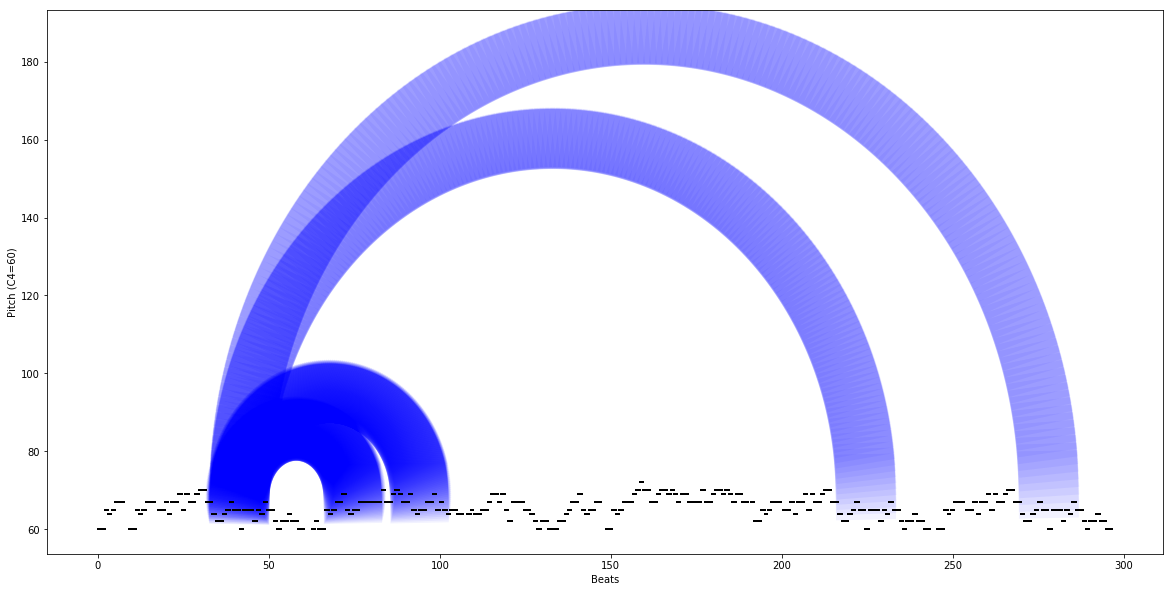

In [36]:
i=7
arcplot.plot(test,tuh["r"]['segind'].iloc[i],tuh["r"]['card'].iloc[i])

In [13]:
from tkinter import *

class Window(Frame):

    def __init__(self, master=None):
        # parameters that you want to send through the Frame class. 
        Frame.__init__(self, master)   

        #reference to the master widget, which is the tk window                 
        self.master = master

        #with that, we want to then run init_window, which doesn't yet exist
        self.init_window()

        
            #Creation of init_window
    def init_window(self):

        # changing the title of our master widget      
        self.master.title("GUI")

        # allowing the widget to take the full space of the root window
        self.pack(fill=BOTH, expand=1)

        # creating a button instance
        quitButton = Button(self, text="Quit", command=self.client_exit)

        # placing the button on my window
        quitButton.place(x=0, y=0)

 
    def client_exit(self):
        print("hello")
        self.destroy()

# root window created. Here, that would be the only window, but
# you can later have windows within windows.

root = Tk()

#size of the window
root.geometry("400x300")

#creation of an instance
app = Window(root)

#mainloop 
root.mainloop()  

hello
